# The agent-environment interaction

In this exercise, you will implement the interaction of a reinforecment learning agent with its environment. We will use the gridworld environment from the second lecture. You will find a description of the environment below, along with two pieces of relevant material from the lectures: the agent-environment interface and the Q-learning algorithm.

1. Create an agent that chooses actions randomly with this environment.

2. Create an agent that uses Q-learning. You can use initial Q values of 0, a stochasticity parameter for the $\epsilon$-greedy policy function $\epsilon=0.05$, and a learning rate $\alpha = 0.1$. But feel free to experiment with other settings of these three parameters.

3. Plot the mean total reward obtained by the two agents through the episodes. This is called a **learning curve**. Run enough episodes for the Q-learning agent to converge to a near-optimal policy.


## The agent-environment interface

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/agent-environment.png" style="width: 500px;" align="left"/>

<br><br><br>

The interaction of the agent with its environments starts at decision stage $t=0$ with the observation of the current state $s_0$. (Notice that there is no reward at this initial stage.) The agent then chooses an action to execute at decision stage $t=1$. The environment responds by changing its state to $s_1$ and returning the numerical reward signal $r_1$.


## The environment: Navigation in a gridworld

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/gold.png" style="width: 250px;" align="left"/>

The agent has four possible actions in each state (grid square): west, north, south, and east. The actions are unreliable. They move the agent in the intended direction with probability 0.8, and with probability 0.2, they move the agent in a random other direction. It the direction of movement is blocked, the agent remains in the same grid square. The initial state of the agent is one of the five grid squares at the bottom, selected randomly. The grid squares with the gold and the bomb are **terminal states**. If the agent finds itself in one of these squares, the episode ends. Then a new episode begins with the agent at the initial state.

You will use a reinforcement learning algorithm to compute the best policy for finding the gold with as few steps as possible while avoiding the bomb. For this, we will use the following reward function: $-1$ for each navigation action, an additional $+10$ for finding the gold, and an additional $-10$ for hitting the bomb. For example, the immediate reward for transitioning into the square with the gold is $-1 + 10 = +9$. Do not use discounting (that is, set $\gamma=1$).

## Q-learning

![title](https://raw.githubusercontent.com/dkasthurirathna/dl/master/q.png)
From Sutton & Barto (1998), Reinforcement Learning.

In [10]:
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline

# Classes for the Enviroment and the Agent

- The GridWorld class contains the environment
- The dimensions of the environment are defined
- Locations of all rewards are stored
- Functions for different methods written
    - `get_available_actions` returns possible actions
    - `agent_on_map` prints out current location of the agent on the grid (used for debugging)
    - `get_reward` returns the reward for an input position
    - `make_step` moves the agent in a specified direction

In [11]:
class GridWorld:
    ## Initialise starting data
    def __init__(self):
        # Set information about the gridworld
        self.height = 8
        self.width = 8
        self.grid = np.zeros(( self.height, self.width)) - 1

        # Set random start location for the agent
        self.current_location = ( 4, np.random.randint(0,5))

        # Set locations for the bomb and the gold
        self.bomb_location = (1,3)
        self.gold_location = (0,3)
        self.terminal_states = [ self.bomb_location, self.gold_location]

        # Set grid rewards for special cells
        self.grid[ self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[ self.gold_location[0], self.gold_location[1]] = 10

        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']


    ## Put methods here:
    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions

    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros(( self.height, self.width))
        grid[ self.current_location[0], self.current_location[1]] = 1
        return grid

    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[ new_location[0], new_location[1]]


    def make_step(self, action):
        """Moves the agent in the specified direction. If agent is at a border, agent stays still
        but takes negative reward. Function returns the reward for the move."""
        # Store previous location
        last_location = self.current_location

        # UP
        if action == 'UP':
            # If agent is at the top, stay still, collect reward
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # DOWN
        elif action == 'DOWN':
            # If agent is at bottom, stay still, collect reward
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # LEFT
        elif action == 'LEFT':
            # If agent is at the left, stay still, collect reward
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 'RIGHT':
            # If agent is at the right, stay still, collect reward
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)

        return reward

    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

In [12]:
class RandomAgent():
    # Choose a random action
    def choose_action(self, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions)

In [13]:
class Q_Agent():
    # Intialise
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment
        self.q_table = dict() # Store all Q-values in dictionary of dictionaries
        for x in range(environment.height): # Loop through all possible grid spaces, create sub-dictionary for each
            for y in range(environment.width):
                self.q_table[(x,y)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0} # Populate sub-dictionary with zero values for possible moves

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def choose_action(self, available_actions):
        """Returns the optimal action from Q-Value table. If multiple optimal actions, chooses random choice.
        Will make an exploratory random action dependent on epsilon."""
        # Epsilon-greedy policy
        if np.random.uniform(0, 1) < self.epsilon:
            # Explore: choose a random action
            action = np.random.choice(available_actions)
        else:
            # Exploit: choose the action with the highest Q-value
            q_values = self.q_table[self.environment.current_location]
            max_q = max(q_values.values())

            # Find all actions with the maximum Q-value
            best_actions = [action for action, q_value in q_values.items() if q_value == max_q]

            # Choose a random action among the best actions
            action = np.random.choice(best_actions)
        return action


    def learn(self, old_state, reward, new_state, action):
        """Updates the Q-value table using Q-learning"""
        old_q_value = self.q_table[old_state][action]
        # Get the maximum Q-value for the new state
        max_q_new_state = max(self.q_table[new_state].values())
        # Q-learning update rule
        new_q_value = old_q_value + self.alpha * (reward + self.gamma * max_q_new_state - old_q_value)
        self.q_table[old_state][action] = new_q_value

In [14]:
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log

    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialise values of each game
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
            old_state = environment.current_location
            action = agent.choose_action(environment.actions)
            reward = environment.make_step(action)
            new_state = environment.current_location

            if learn == True: # Update Q-values if learning is specified
                agent.learn(old_state, reward, new_state, action)

            cumulative_reward += reward
            step += 1

            if environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
                environment.__init__()
                game_over = True

        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log

    return reward_per_episode # Return performance log

## Run Random Agent

- Random agent moves randomly and does not learn from it's actions.
- This gives a base performance to compare the Q-Learning agent to

In [15]:
env = GridWorld()
agent = RandomAgent()

print("Current position of the agent =", env.current_location)
print(env.agent_on_map())
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", env.current_location)
print(env.agent_on_map())

Current position of the agent = (4, 4)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
Available_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
Randomly chosen action = UP
Reward obtained = -1.0
Current position of the agent = (3, 4)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


- Here the random agent is ran for 500 trials
- Performance is obviously inconsistent and not optimal

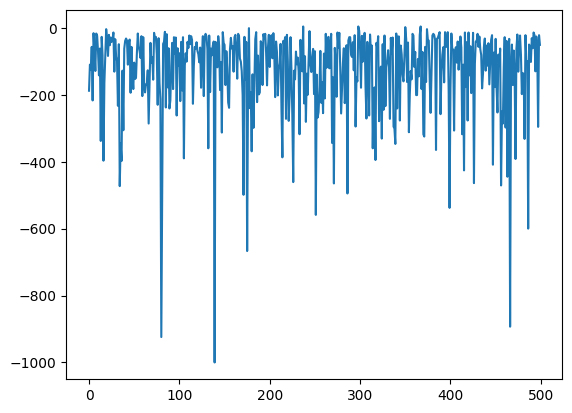

In [16]:
# Initialize environment and agent
environment = GridWorld()
random_agent = RandomAgent()

reward_per_episode = play(environment, random_agent, trials=500)

# Simple learning curve
plt.plot(reward_per_episode)

## Q-Agent

- Here the Q-Learning agent is ran for 500 trials again
- Performance is plotted
- Performance increases greatly

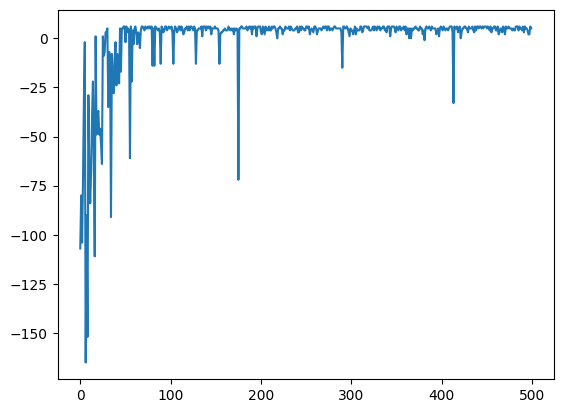

In [17]:
environment = GridWorld()
agentQ = Q_Agent(environment)

# Note the learn=True argument!
reward_per_episode = play(environment, agentQ, trials=500, learn=True)

# Simple learning curve
plt.plot(reward_per_episode)

Print the final Q-value table with nice formatting.

In [18]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))


pretty(agentQ.q_table)

(0, 0)
	UP
		-0.30000000000000004
	DOWN
		-0.320099
	LEFT
		-0.30000000000000004
	RIGHT
		-0.3592
(0, 1)
	UP
		-0.2
	DOWN
		-0.2
	LEFT
		-0.2
	RIGHT
		5.4358746149899275
(0, 2)
	UP
		0.08100000000000002
	DOWN
		2.751073531566337
	LEFT
		1.3452220938994315
	RIGHT
		9.999999999999993
(0, 3)
	UP
		0
	DOWN
		0
	LEFT
		0
	RIGHT
		0
(0, 4)
	UP
		1.589699022354659
	DOWN
		2.505075429446708
	LEFT
		9.999784852669011
	RIGHT
		-0.1
(0, 5)
	UP
		-0.2
	DOWN
		-0.218
	LEFT
		0.3685590000000001
	RIGHT
		-0.2
(0, 6)
	UP
		-0.4
	DOWN
		-0.41585000000000005
	LEFT
		-0.36190000000000005
	RIGHT
		-0.41000000000000003
(0, 7)
	UP
		-0.5
	DOWN
		-0.5186498
	LEFT
		-0.4729
	RIGHT
		-0.5
(1, 0)
	UP
		-0.47990000000000005
	DOWN
		-0.5704390438388269
	LEFT
		-0.5
	RIGHT
		-0.4333370858893512
(1, 1)
	UP
		-0.281
	DOWN
		-0.33809100000000003
	LEFT
		-0.30000000000000004
	RIGHT
		4.54416821473688
(1, 2)
	UP
		8.999999999999986
	DOWN
		2.594177271215951
	LEFT
		0.8814779368132606
	RIGHT
		-3.439
(1, 3)
	UP
		0
	DOW

# Screenshots


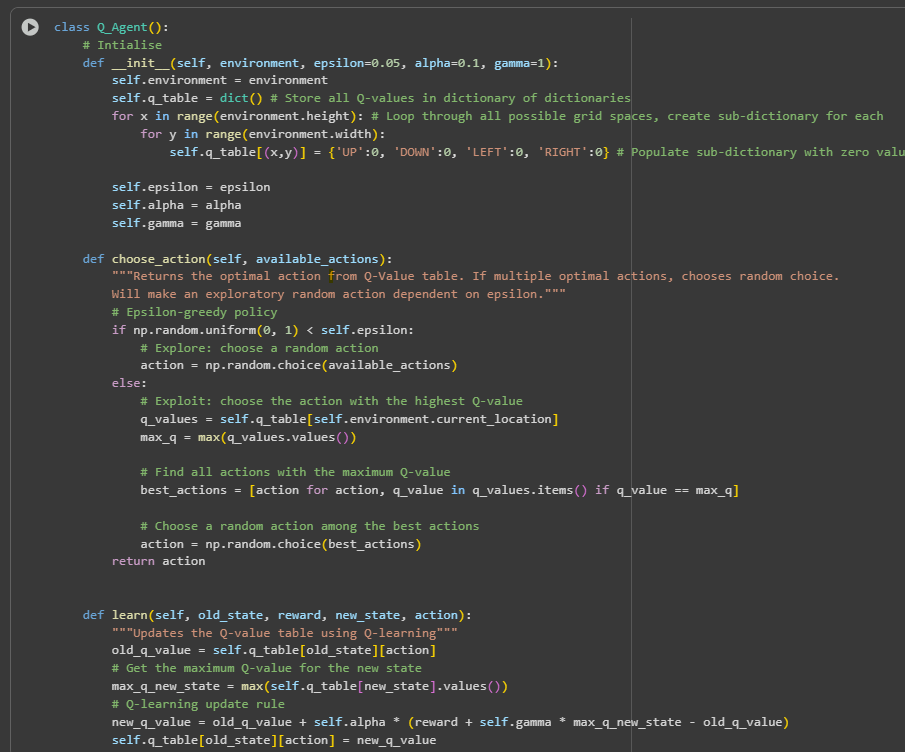



```
# This is formatted as code
```

# Question
## In the GridWorld notebook, increase the grid size to a large value to observe execution time.

Starting grid size scaling experiment...

Running simulation for a 8x8 grid...
Simulation for 8x8 grid completed in 2.1203 seconds.

Running simulation for a 16x16 grid...
Simulation for 16x16 grid completed in 2.1540 seconds.

Running simulation for a 32x32 grid...
Simulation for 32x32 grid completed in 2.5437 seconds.

--- Summary of Results ---
| Grid Size | Execution Time (s) |
|-----------|--------------------|
| 8x8     | 2.1203             |
| 16x16     | 2.1540             |
| 32x32     | 2.5437             |


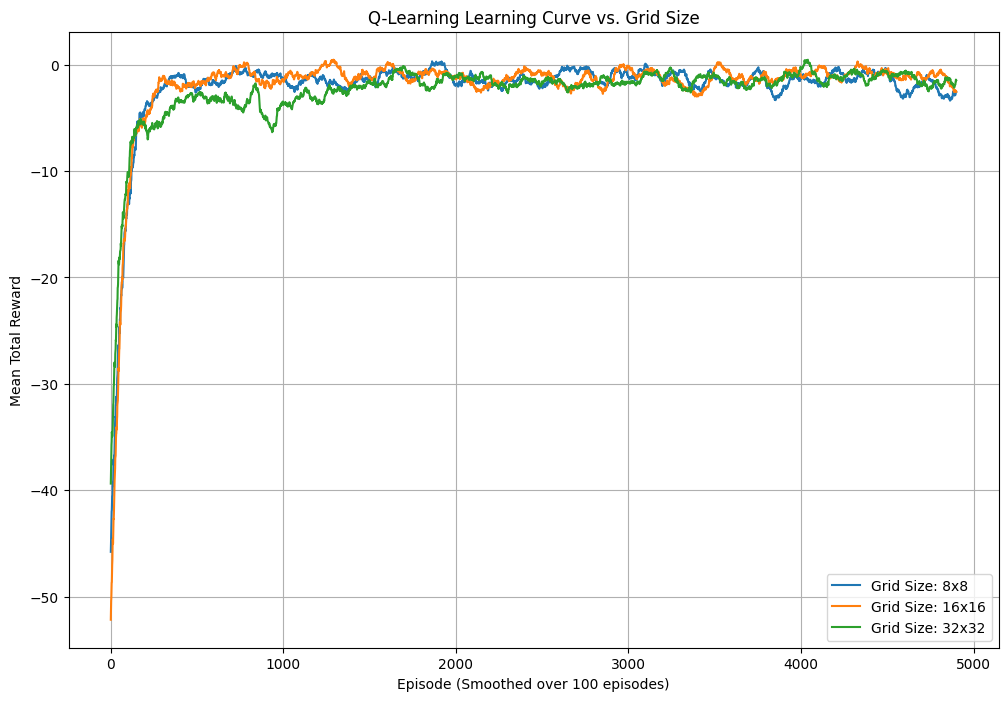

In [19]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import timeit

# The GridWorld environment class
class GridWorld:
    ## Initialise starting data
    def __init__(self, size=8):
        # Set information about the gridworld
        self.height = size
        self.width = size
        self.grid = np.zeros((self.height, self.width)) - 1 # -1 reward for all non-special states

        # Set locations for the bomb and the gold
        self.gold_location = (0, 3)
        self.bomb_location = (1, 3)
        self.terminal_states = [self.bomb_location, self.gold_location]

        # Set grid rewards for special cells (only if indices are valid)
        if self.height > 1 and self.width > 3:
            self.grid[self.bomb_location[0], self.bomb_location[1]] = -10
            self.grid[self.gold_location[0], self.gold_location[1]] = 10

        # Set random start location for the agent
        start_row = self.height - 1
        self.current_location = (np.random.randint(start_row - 4, start_row + 1), np.random.randint(0, self.width))
        while self.current_location in self.terminal_states:
             self.current_location = (np.random.randint(start_row - 4, start_row + 1), np.random.randint(0, self.width))

        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']

    def get_available_actions(self):
        return self.actions

    def agent_on_map(self):
        grid = np.zeros((self.height, self.width))
        grid[self.current_location[0], self.current_location[1]] = 1
        return grid

    def get_reward(self, new_location):
        return self.grid[new_location[0], new_location[1]]

    def _deterministic_step(self, action, current_location):
        # Helper to calculate the intended next state, handling boundary bounce
        r, c = current_location

        if action == 'UP':
            r_new, c_new = max(0, r - 1), c
        elif action == 'DOWN':
            r_new, c_new = min(self.height - 1, r + 1), c
        elif action == 'LEFT':
            r_new, c_new = r, max(0, c - 1)
        elif action == 'RIGHT':
            r_new, c_new = r, min(self.width - 1, c + 1)

        return (r_new, c_new)

    def make_step(self, intended_action):
        """Moves the agent in the specified direction with 0.8/0.2 stochasticity."""
        last_location = self.current_location

        p = np.random.uniform(0, 1)
        if p < 0.8:
            actual_action = intended_action
        else:
            other_actions = [a for a in self.actions if a != intended_action]
            actual_action = np.random.choice(other_actions)

        new_location = self._deterministic_step(actual_action, last_location)
        self.current_location = new_location

        reward = self.get_reward(self.current_location)

        return reward

    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb)."""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

# The Q-Learning agent class
class Q_Agent():
    # Intialise
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment
        self.q_table = dict() # Store all Q-values in dictionary of dictionaries
        for x in range(environment.height): # Loop through all possible grid spaces, create sub-dictionary for each
            for y in range(environment.width):
                self.q_table[(x,y)] = {action: 0 for action in environment.actions} # Populate sub-dictionary with zero values for possible moves

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def choose_action(self, current_location, available_actions):
        """Returns the optimal action from Q-Value table. If multiple optimal actions, chooses random choice.
        Will make an exploratory random action dependent on epsilon."""
        # #type your code here
        if np.random.uniform(0, 1) < self.epsilon:
            # Explore: Choose a random action
            action = np.random.choice(available_actions)
        else:
            # Exploit: Choose the greedy action
            q_values = self.q_table[current_location]

            # Find action(s) with max Q-value (handling ties randomly)
            max_q = max(q_values.values())
            best_actions = [action for action, q_val in q_values.items() if q_val == max_q]
            action = np.random.choice(best_actions)

        return action
        # #end of type your code here

    def learn(self, old_state, reward, new_state, action):
        """Updates the Q-value table using Q-learning"""
        # #type your code here

        # Get current Q-value Q(s, a)
        old_q = self.q_table[old_state][action]

        # Get max Q-value for next state max_a' Q(s', a')
        if new_state in self.environment.terminal_states:
            # If new state is terminal, max Q-value is 0
            max_future_q = 0
        else:
            max_future_q = max(self.q_table[new_state].values())

        # Q-learning formula: Q(s,a) <- Q(s,a) + alpha * [ r + gamma * max_a' Q(s',a') - Q(s,a) ]
        new_q = old_q + self.alpha * (reward + self.gamma * max_future_q - old_q)

        # Update Q-table
        self.q_table[old_state][action] = new_q
        # #end of type your code here

def play(environment, agent, trials=500, max_steps_per_episode=100, learn=True):
    """
    Plays the game for a number of trials and records rewards.
    Fixed to pass the current state to the agent's choose_action method.
    """
    reward_per_episode = []
    for trial in range(trials):
        game_over = False
        step = 0
        environment.__init__() # Reset environment for each trial

        total_reward = 0
        while step < max_steps_per_episode and game_over != True:
            old_state = environment.current_location

            # Corrected call to choose_action, now passing current_location
            action = agent.choose_action(old_state, environment.actions)

            reward = environment.make_step(action)
            new_state = environment.current_location

            if learn:
                agent.learn(old_state, reward, new_state, action)

            if environment.check_state() == 'TERMINAL':
                game_over = True

            total_reward += reward
            step += 1

        reward_per_episode.append(total_reward)
    return reward_per_episode


# --- Task 5: Increase grid size and observe changes ---

# Define the grid sizes and corresponding number of episodes to run
# Larger grids require more episodes to converge
GRID_SIZES_TO_TEST = [8, 16, 32]
NUM_EPISODES = 5000

# Dictionary to store results
results = {}

print("Starting grid size scaling experiment...")

for size in GRID_SIZES_TO_TEST:
    print(f"\nRunning simulation for a {size}x{size} grid...")
    environment = GridWorld(size=size)
    agentQ = Q_Agent(environment)

    start_time = timeit.default_timer()
    reward_per_episode = play(environment, agentQ, trials=NUM_EPISODES, learn=True)
    end_time = timeit.default_timer()

    execution_time = end_time - start_time

    # Store the results
    results[size] = {
        'time': execution_time,
        'rewards': reward_per_episode
    }

    print(f"Simulation for {size}x{size} grid completed in {execution_time:.4f} seconds.")

print("\n--- Summary of Results ---")
print("| Grid Size | Execution Time (s) |")
print("|-----------|--------------------|")
for size, data in results.items():
    print(f"| {size}x{size}     | {data['time']:.4f}             |")

# Plotting the learning curves for each grid size to observe convergence
plt.figure(figsize=(12, 8))
for size, data in results.items():
    # Smoothen the reward curve for better visualization of convergence
    window = 100
    smoothed_rewards = np.convolve(data['rewards'], np.ones(window)/window, mode='valid')
    plt.plot(smoothed_rewards, label=f'Grid Size: {size}x{size}')

plt.title('Q-Learning Learning Curve vs. Grid Size')
plt.xlabel(f'Episode (Smoothed over {window} episodes)')
plt.ylabel('Mean Total Reward')
plt.legend()
plt.grid(True)
plt.show()
